In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
#from sklearn.learning_curve import validation_curve
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error
from sklearn.cluster import KMeans
import statsmodels.api as sm
import math
from scipy import stats
from scipy.stats import boxcox
from scipy.special import boxcox1p


In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
*The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


In [3]:
# Load dataframe and add/clean columns

In [4]:
df = pd.read_csv('nfl_betting_df.csv', index_col = 0)

In [5]:
df['exp_win_difference'] = df.home_exp_win_pct- df.away_exp_win_pct
df['schedule_date']=df['schedule_date'].apply(pd.to_datetime)
df = df[df.schedule_season > 1978]

df['total_ppg'] = (df.h_ppg + df.a_ppg)
df['total_points_against'] = (df.h_papg + df.a_papg)
df['last_four_difference'] = (df.home_win_pct_last_4 - df.away_win_pct_last_4)

df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']]=df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']].fillna(value=np.round(df.mean(),3))
df[['over_under_line']]=df[['over_under_line']].fillna(value=(np.round(df.mean()*2)/2))

df['over_under_result'] = np.where(df['over_under_result']=='under', 0, df.over_under_result)
df['over_under_result'] = np.where(df['over_under_result']=='over', 1, df.over_under_result)
df['over_under_result'] = np.where(df['over_under_result']=='push', 2, df.over_under_result)

df['dome'] = np.where(df['weather_detail']=='DOME', 1, 0)

df = df.fillna(value = 0)

df.index = range(0, len(df))

In [6]:
reg_df = df[(df.schedule_week > 1) & (df.schedule_week < 19) & (df.schedule_season>2001)]
week5_df = df[(df.schedule_week > 4) & (df.schedule_week < 17) & (df.schedule_season>2001)]

In [7]:
# SPlit games into clusters


In [8]:
cluster_df = pd.read_csv('cluster_df.csv',index_col=0)
cluster_df['spread_favorite'] = abs(cluster_df.spread_favorite)
good_o_bad_d = cluster_df[cluster_df.cluster==3]
good_o_good_d = cluster_df[cluster_df.cluster==1]
bad_o_bad_d = cluster_df[cluster_df.cluster==0]
bad_o_good_d = cluster_df[cluster_df.cluster==2]

In [9]:
# Regression Formulas

In [10]:
def poly_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(x,y)
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)
    
#     #conditional to plot points in diff color depending on game outcome
#     if str(y) == str(reg_df.over_under_line):
#         y1 = y[week5_df['over_under_result']==1]
#         y2 = y[week5_df['over_under_result']==0]
#         y3 = y[week5_df['over_under_result']==2]
#         x1 = x[week5_df['over_under_result']==1]
#         x2 = x[week5_df['over_under_result']==0]
#         x3 = x[week5_df['over_under_result']==2]
#         plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
#         plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
#         plt.scatter(x3, y3, s = s, alpha = .4, color = 'yellow', label = 'Push')
#     else:
#         y1 = y[week5_df['favorite_covered']==1]
#         y2 = y[week5_df['favorite_covered']==0]
#         y3 = y[week5_df['favorite_covered']==2]
#         x1 = x[week5_df['favorite_covered']==1]
#         x2 = x[week5_df['favorite_covered']==0]
#         x3 = x[week5_df['favorite_covered']==2]
#         plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
#         plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
#         plt.scatter(x3, y3, s = s, alpha = .4, color = 'yellow', label = 'Push')
        
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')


In [11]:
def log_linear_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    #create figure and set size and axis lims
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(x, np.log(np.abs(y)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)

    #conditional to plot points in diff color depending on game outcome
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']==1]
        y2 = y[reg_df['over_under_result']==0]
        x1 = x[reg_df['over_under_result']==1]
        x2 = x[reg_df['over_under_result']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')

In [12]:
def log_log_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    #create figure and set size and axis lims
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(np.log(x+1), np.log(np.abs(y)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)

    #conditional to plot points in diff color depending on game outcome
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']==1]
        y2 = y[reg_df['over_under_result']==0]
        x1 = x[reg_df['over_under_result']==1]
        x2 = x[reg_df['over_under_result']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')

In [13]:
# Regression Evaluations

In [14]:
def rmse_check(predictions, targets):

    differences = predictions - targets                       #the DIFFERENCEs.

    differences_squared = differences ** 2                    #the SQUAREs of ^

    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^

    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^

    return rmse_val                                           #get the ^

In [15]:
def regression_evaluation(target, X_list):
    split = train_test_split(X_list, target,random_state=69)
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
     
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    rmse = math.sqrt(mean_squared_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted
    
    plt.scatter(y_predicted,residuals)
    check = round(rmse_check(y_predicted, y_actual) - rmse)
    print(est2.summary())
    plt.scatter(y_predicted,residuals)
    plt.show()
    sns.distplot(residuals)
    print(est2.params)
    print('RMSE=' + str(rmse) + ', check =' + str(check))

In [16]:
def log_log_regression_evaluation(target, X_list):
    split = train_test_split((np.log(np.abs(X_list)+1)), np.log(np.abs(target)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
    
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    
    log_rmse = math.sqrt(mean_squared_log_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted

    #plt.scatter(y_predicted,residuals)
    print(est2.summary())
    sns.distplot(residuals)
    print('Log RMSE=' + str(log_rmse))

In [17]:
def log_linear_regression_evaluation(target,X_list):
    split = train_test_split(X_list, np.log(np.abs(target)+1))## log-linear eval
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
    
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    
    log_rmse = math.sqrt(mean_squared_log_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted

    #plt.scatter(y_predicted,residuals)
    print(est2.summary())
    sns.distplot(residuals)
    print('Log RMSE=' + str(log_rmse))

In [18]:
## BoxCox Transformation for Over Under Line

In [19]:
yt,max_lambda =boxcox(good_o_bad_d.spread_favorite + .01)
# yt,max_lambda
# print(min(yt),max(yt))

# Variable 1 -Exp Win Difference

In [20]:
xt1,x1_lam=boxcox(good_o_bad_d.exp_win_difference + 1.01)
# xt1,x1_lam
# print(min(xt1),max(xt1))

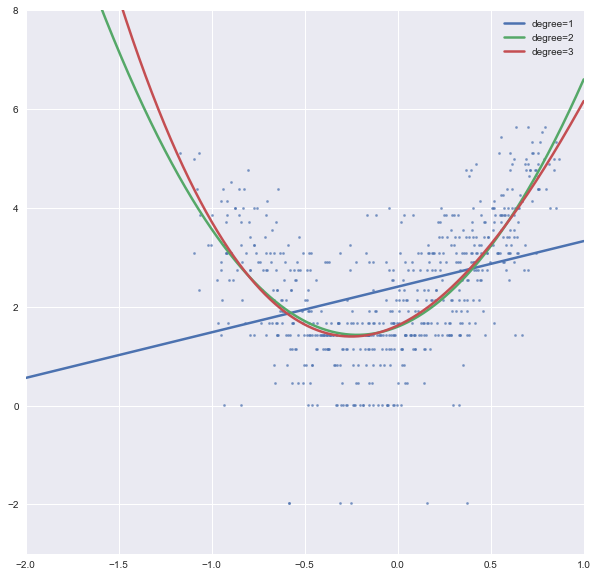

In [21]:
poly_regression(xt1, yt,[1,2,3], -2,1, -3,8)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     197.7
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           2.98e-39
Time:                        18:15:05   Log-Likelihood:                -987.90
No. Observations:                 631   AIC:                             1980.
Df Residuals:                     629   BIC:                             1989.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7881      0.064     28.139      0.0

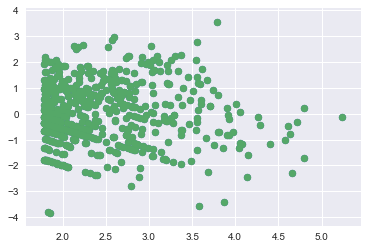

[1.78814158 2.5116931 ]
RMSE=1.157971392638765, check =0.0


/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


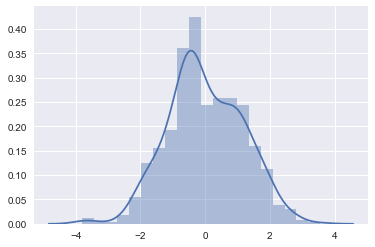

In [22]:
regression_evaluation(yt,xt1**2)

# Variable 2 - Total PPG

In [23]:
xt2,x2_lam=boxcox(good_o_bad_d.last_four_difference + 1.01)
# xt2,x2_lam
# print(min(xt2),max(xt2))

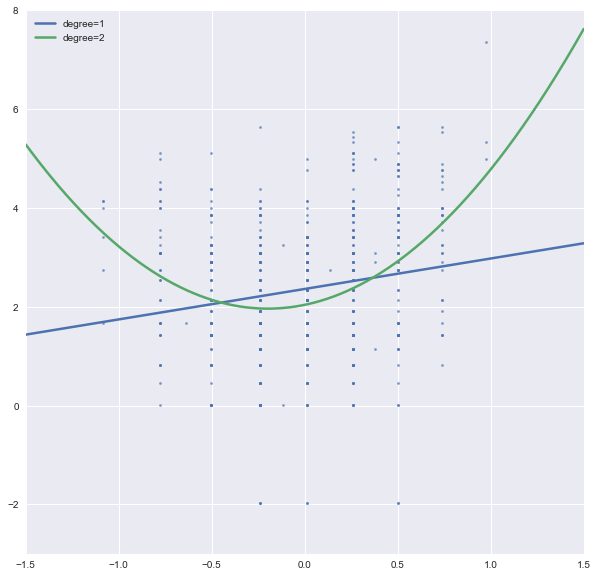

In [24]:
poly_regression(xt2,yt,[1,2],-1.5,1.5,-3,8)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     46.41
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           2.25e-11
Time:                        18:15:06   Log-Likelihood:                -1051.7
No. Observations:                 631   AIC:                             2107.
Df Residuals:                     629   BIC:                             2116.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1239      0.065     32.473      0.0

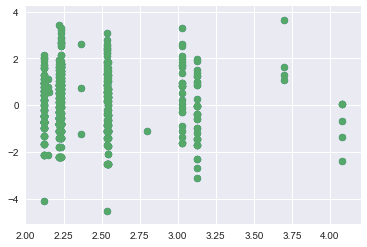

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[2.12387971 1.65736301]
RMSE=1.2811446794207593, check =0.0


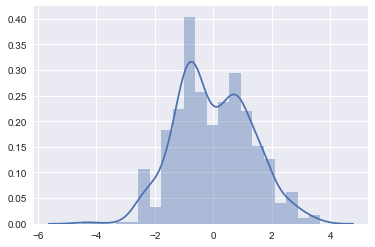

In [25]:
regression_evaluation(yt,xt2**2)

# Variable 3 - Home Favorite

In [26]:
xt3,x3_lam=boxcox(good_o_bad_d.home_favorite + .01)
# xt3,x3_lam
# print(min(xt3),max(xt3))

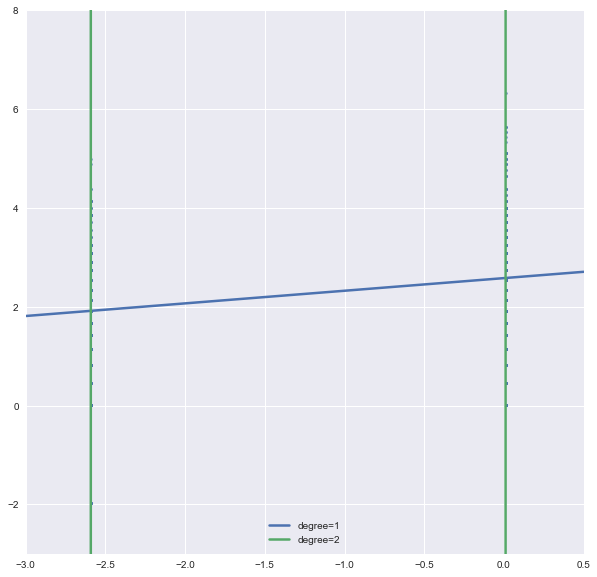

In [27]:
poly_regression(xt3,yt,[1,2],-3,.5,-3,8)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     28.73
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           1.17e-07
Time:                        18:15:07   Log-Likelihood:                -1060.1
No. Observations:                 631   AIC:                             2124.
Df Residuals:                     629   BIC:                             2133.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6277      0.067     39.388      0.0

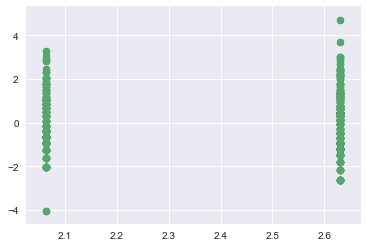

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[2.6277104  0.21746233]
RMSE=1.2982533085443808, check =0.0


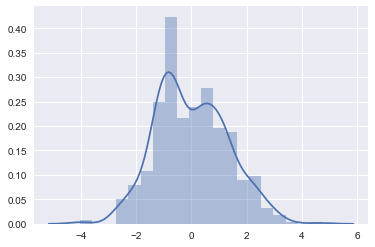

In [28]:
regression_evaluation(yt,xt3)

# Regression of Spread - Good Offense, Bad Defense

In [29]:
yt,max_lambda =boxcox(good_o_bad_d.spread_favorite + .01)
xt1,x1_lam=boxcox(good_o_bad_d.exp_win_difference + 1.01)
xt2,x2_lam=boxcox(good_o_bad_d.last_four_difference + 1.01)
xt3,x3_lam=boxcox(good_o_bad_d.home_favorite + .01)

gobd_df = pd.DataFrame([xt1**2,xt2,xt3]).T
gobd_df.columns=['Exp Win Difference','Last 4 Difference','Home Favorite']
# gobd_df.head()
# len(gobd_df)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     145.6
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           1.37e-71
Time:                        18:15:08   Log-Likelihood:                -907.37
No. Observations:                 631   AIC:                             1823.
Df Residuals:                     627   BIC:                             1841.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.9514      0

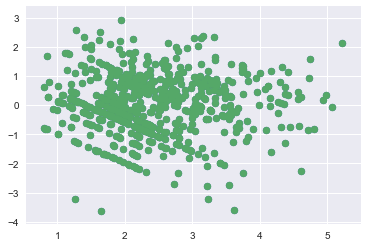

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


const                 1.951360
Exp Win Difference    3.157920
Last 4 Difference     0.759295
Home Favorite         0.294665
dtype: float64
RMSE=1.019226569742839, check =0.0


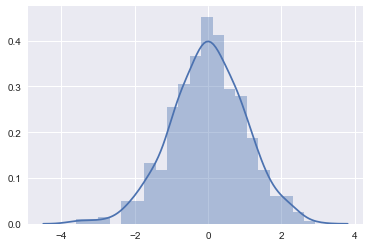

In [30]:
regression_evaluation(yt,gobd_df)

# Good Offense, Good Defense

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     138.7
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           2.51e-69
Time:                        18:15:09   Log-Likelihood:                -926.16
No. Observations:                 648   AIC:                             1860.
Df Residuals:                     644   BIC:                             1878.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.8231      0

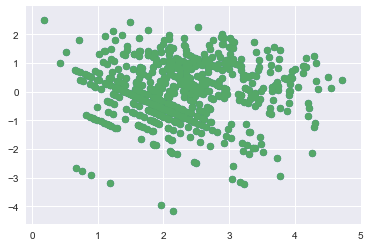

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


const                 1.823109
Exp Win Difference    2.902407
Last 4 Difference     0.885878
Home Favorite         0.371631
dtype: float64
RMSE=1.0103704911769549, check =-0.0


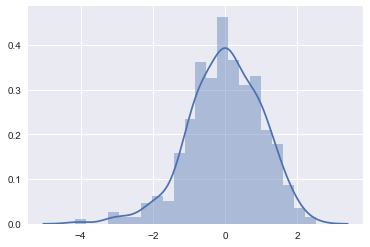

In [31]:
cluster_name = good_o_good_d

yt,max_lambda =boxcox(cluster_name.spread_favorite + .01)
xt1,x1_lam=boxcox(cluster_name.exp_win_difference + 1.01)
xt2,x2_lam=boxcox(cluster_name.last_four_difference + 1.01)
xt3,x3_lam=boxcox(cluster_name.home_favorite + .01)

gogd_df = pd.DataFrame([xt1**2,xt2,xt3]).T
gogd_df.columns=['Exp Win Difference','Last 4 Difference','Home Favorite']


regression_evaluation(yt,gogd_df)

# Bad Offense, Bad Defense

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     127.8
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           2.79e-63
Time:                        18:15:10   Log-Likelihood:                -834.75
No. Observations:                 572   AIC:                             1678.
Df Residuals:                     568   BIC:                             1695.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.8125      0

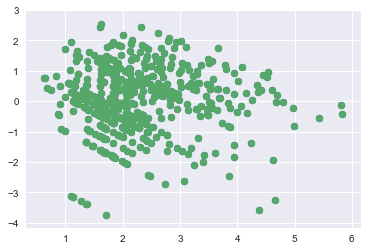

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


const                 1.812475
Exp Win Difference    4.064444
Last 4 Difference     0.907942
Home Favorite         0.214088
dtype: float64
RMSE=1.0412482569555992, check =0.0


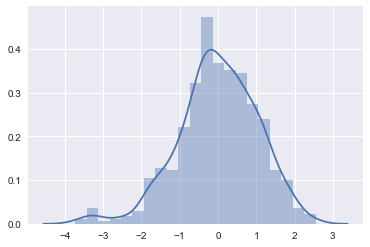

In [32]:
cluster_name = bad_o_bad_d

yt,max_lambda =boxcox(cluster_name.spread_favorite + .01)
xt1,x1_lam=boxcox(cluster_name.exp_win_difference + 1.01)
xt2,x2_lam=boxcox(cluster_name.last_four_difference + 1.01)
xt3,x3_lam=boxcox(cluster_name.home_favorite + .01)

bobd_df = pd.DataFrame([xt1**2,xt2,xt3]).T
bobd_df.columns=['Exp Win Difference','Last 4 Difference','Home Favorite']

regression_evaluation(yt,bobd_df)

# Bad Offense, Good Defense

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     53.65
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           6.87e-30
Time:                        18:15:11   Log-Likelihood:                -748.03
No. Observations:                 480   AIC:                             1504.
Df Residuals:                     476   BIC:                             1521.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.9241      0

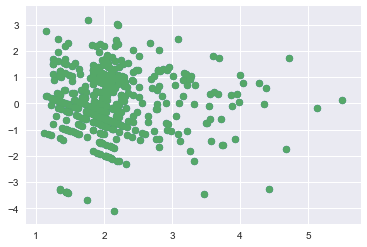

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


const                 1.924139
Exp Win Difference    3.718865
Last 4 Difference     0.383322
Home Favorite         0.281423
dtype: float64
RMSE=1.149648503894987, check =-0.0


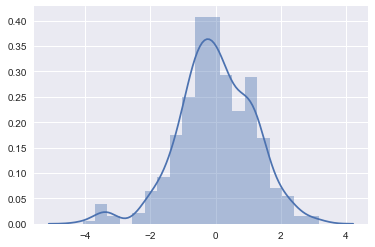

In [33]:
cluster_name = bad_o_good_d

yt,max_lambda =boxcox(cluster_name.spread_favorite + .01)
xt1,x1_lam=boxcox(cluster_name.exp_win_difference + 1.01)
xt2,x2_lam=boxcox(cluster_name.last_four_difference + 1.01)
xt3,x3_lam=boxcox(cluster_name.home_favorite + .01)

bogd_df = pd.DataFrame([xt1**2,xt2,xt3]).T
bogd_df.columns=['Exp Win Difference','Last 4 Difference','Home Favorite']

regression_evaluation(yt,bogd_df)